In [ ]:
!curl -L "https://universe.roboflow.com/ds/i6iI8rxce6?key=UUJz9Ns2Sf" > roboflow.zip
!unzip roboflow.zip
!rm roboflow.zip
!mkdir data
!cp -R test/* data/
!cp -R train/* data/
!cp -R valid/* data/
!rm -rf test/ train/ valid/ README*

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   900  100   900    0     0   3498      0 --:--:-- --:--:-- --:--:--  3488
100 48.2M  100 48.2M    0     0  34.2M      0  0:00:01  0:00:01 --:--:-- 90.8M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/122_jpeg_jpg.rf.5b8788f6ee5bca71750ec1b95c2ce2ff.jpg  
 extracting: test/122_jpeg_jpg.rf.5b8788f6ee5bca71750ec1b95c2ce2ff.xml  
 extracting: test/127_jpeg_jpg.rf.bfdbf826ecdd281db206377e74417166.jpg  
 extracting: test/127_jpeg_jpg.rf.bfdbf826ecdd281db206377e74417166.xml  
 extracting: test/128_jpeg_jpg.rf.afda06dddc3b556adfb5a8cd3e64f54f.jpg  
 extracting: test/128_jpeg_jpg.rf.afda06dddc3b556adfb5a8cd3e64f54f.xml  
 extracting: test/138_jpeg_jpg.rf.93f75f3f1beff273d71c07c408df12f9.jpg  
 extracting: test/138_jpeg_jpg.rf.93f75f3f1beff273d71c0

In [ ]:
!pip install keras-cv pybboxes
import os
import tensorflow as tf
from tensorflow import keras
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

import pybboxes as pbx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.2 MB/s eta 0:00:00
Using TensorFlow backend


In [ ]:
# global paths
gl_images = "/Users/nysa/desd-assignment/AI/others/self/export/images"
gl_labels = "/content/data/"
# train_images = "/Users/nysa/desd-assignment/AI/others/s2/train/images"
# train_labels = "/Users/nysa/desd-assignment/AI/others/s2/train/labels"

gl_lbls = [
    "button",
    "checkbox",
    "container",
    "icon-button",
    "image",
    "input",
    "label",
    "link",
    "number-input",
    "radio",
    "search",
    "select",
    "slider",
    "table",
    "text",
    "textarea",
    "textbox",
    "toggle",
]

class_mapping = dict(zip(range(len(gl_lbls)), gl_lbls))

In [ ]:
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(gl_labels, file_name)
        for file_name in os.listdir(gl_labels)
        if file_name.endswith(".xml")
    ]
)


# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(gl_labels, file_name)
        for file_name in os.listdir(gl_labels)
        if file_name.endswith(".jpg")
    ]
)

print(f"Total XML files: {len(xml_files)}"
        f"\nTotal JPEG files: {len(jpg_files)}")

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(gl_labels, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

Total XML files: 1620
Total JPEG files: 1620


  0%|          | 0/1620 [00:00<?, ?it/s]

In [ ]:
files = tf.ragged.constant(image_paths)
labels = tf.ragged.constant(classes)
bboxes = tf.ragged.constant(bbox)

files.shape, labels.shape, bboxes.shape

(TensorShape([1620]),
 TensorShape([1620, None]),
 TensorShape([1620, None, None]))

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((files, labels, bboxes))

# Split the dataset into train and validation sets
train_size = int(0.7 * len(dataset))
train_data = dataset.take(train_size)
val_data = dataset.skip(train_size)

BATCH_SIZE = 4
print(len(dataset))
print("Train Size: ", len(train_data))
print("Validation Size: ", len(val_data))

1620
Train Size:  1134
Validation Size:  486


In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [ ]:
bbxf = "xyxy"

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

In [ ]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
augmenters = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=bbxf),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format=bbxf
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format=bbxf
        ),
    ]
)
train_ds = train_ds.map(augmenters, num_parallel_calls=tf.data.AUTOTUNE)
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format=bbxf,
)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

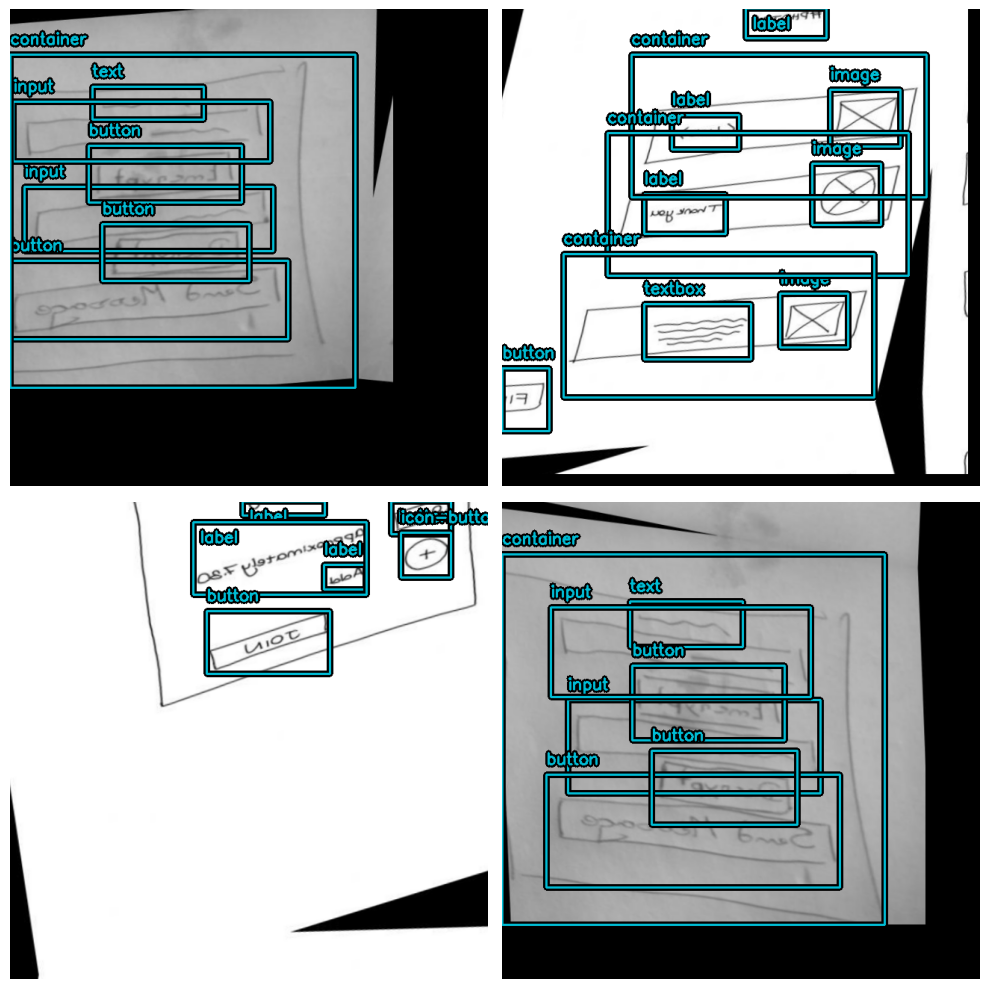

In [ ]:
visualize_dataset(
    train_ds,
    bounding_box_format=bbxf,
    value_range=(0, 255),
    rows=2,
    cols=2,
)

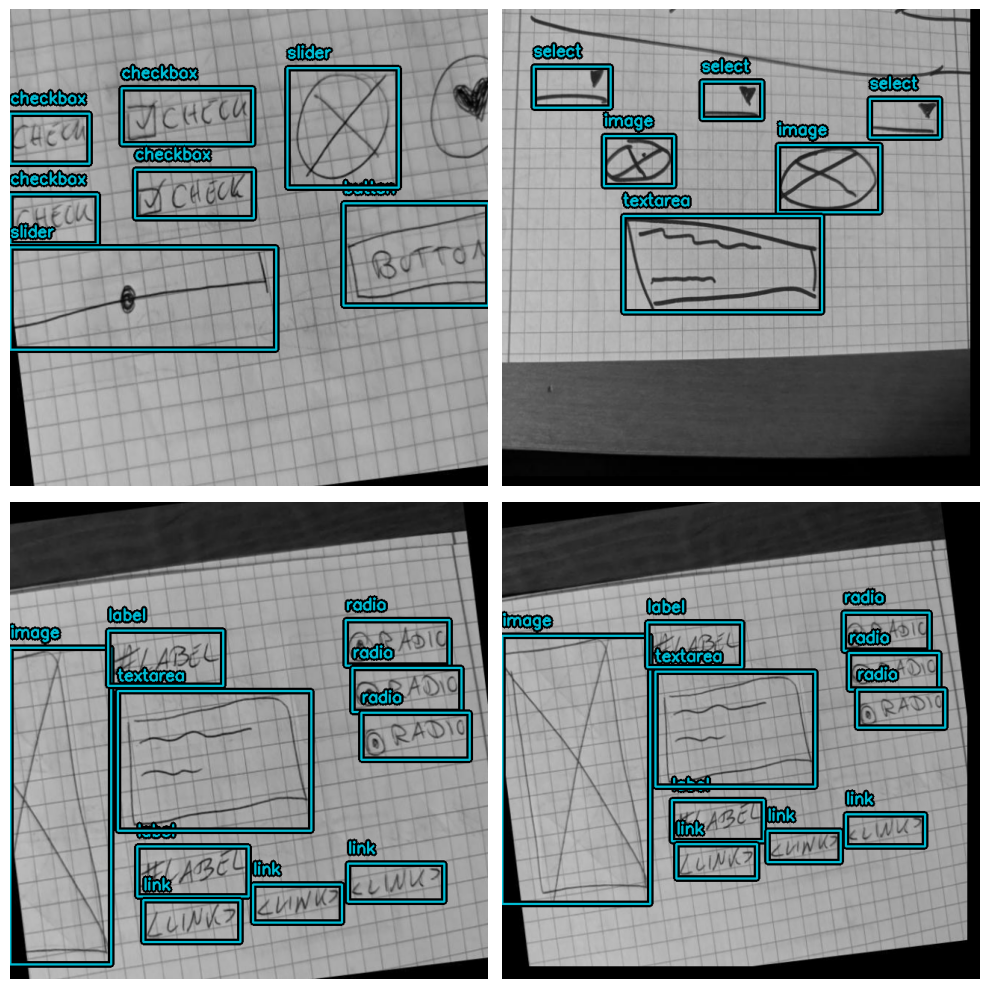

In [ ]:
visualize_dataset(
    val_ds,
    bounding_box_format=bbxf,
    value_range=(0, 255),
    rows=2,
    cols=2,

)

In [ ]:
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_l_backbone"  # We will use yolov8 small backbone with coco weights
)

100%|██████████| 633/633 [00:00<00:00, 1.57MB/s]


In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format=bbxf,
    backbone=backbone,
    fpn_depth=1,
)

# print(yolo.summary())

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [ ]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)


yolo.fit(
  # Run for 10-35~ epochs to achieve good scores.
  train_ds,
  epochs=30,
  callbacks=[callback],
  validation_data=val_ds,
)

Epoch 1/30
283/283 [==============================] - 214s 754ms/step - loss: 2.4692 - box_loss: 2.2058 - class_loss: 0.2634 - val_loss: 3.7899 - val_box_loss: 3.4543 - val_class_loss: 0.3355
Epoch 2/30
283/283 [==============================] - 209s 734ms/step - loss: 2.3077 - box_loss: 2.0856 - class_loss: 0.2221 - val_loss: 3.0879 - val_box_loss: 2.8241 - val_class_loss: 0.2638
Epoch 3/30
283/283 [==============================] - 193s 678ms/step - loss: 2.0782 - box_loss: 1.8854 - class_loss: 0.1929 - val_loss: 3.0388 - val_box_loss: 2.7870 - val_class_loss: 0.2518
Epoch 4/30
283/283 [==============================] - 194s 682ms/step - loss: 1.9697 - box_loss: 1.7965 - class_loss: 0.1732 - val_loss: 2.6758 - val_box_loss: 2.4537 - val_class_loss: 0.2221
Epoch 5/30
283/283 [==============================] - 194s 681ms/step - loss: 1.8023 - box_loss: 1.6469 - class_loss: 0.1555 - val_loss: 2.5986 - val_box_loss: 2.3893 - val_class_loss: 0.2093
Epoch 6/30
283/283 [====================

In [ ]:
# save with current timestamp as name
import datetime
time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
yolo.save("/content/model/yolo.keras")

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 3s 3s/step


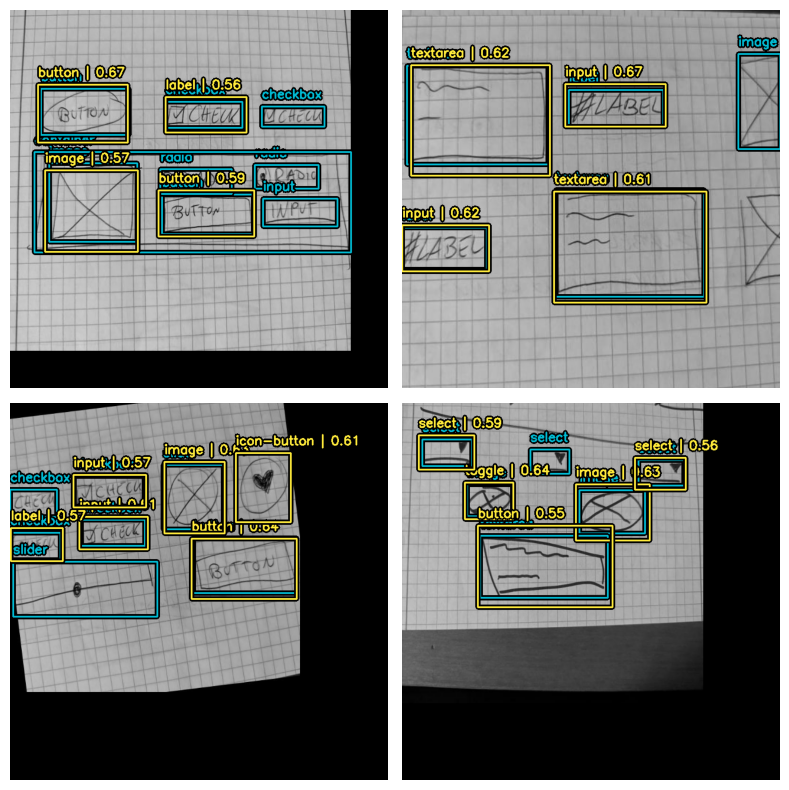

In [ ]:
# get latest saved in freeze folder

model = yolo

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format=bbxf,
    from_logits=True,
    iou_threshold=0.45,
    confidence_threshold=0.55,
)

visualize_detections(model, dataset=val_ds, bounding_box_format=bbxf)